# EXTRA EXERCISE 2

The data of `general_motors.csv` report the daily changes of the General Motors Co. closing prices since September 4, 1998 to November 27, 1998. 
1. Design a suitable quality control tool by assuming the
existence of an assignable cause for the OOC observations if any. 
2. Determine if the values reported in the array `new_obs` are IC (use the previously designed control chart point 1). 
`new_obs = np.array((1.327, 1.594, 0.716, 1.767, 0.915, 2.524, 0.563, 2.053))`

In [ ]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import qdatoolkit as qda

# Import the dataset
data = pd.read_csv('../../Data/general_motors.csv')

# Inspect the dataset
data.head()

## Point 1

Design a suitable quality control tool by assuming the existence of an assignable cause for the OOC observations (if any).

> ### Solution
>
> Let's plot the data first.

In [ ]:
# Plot the data
plt.plot(data, 'o-')
plt.show()

> Looks like there's one point with a value much higher than the others. But let's test all assumptions first.

> Perform the runs test to check if the data are random. Plot the autocorrelation and partial autocorrelation functions of the data. 

In [ ]:
qda.Assumptions(data['GM']).independence()

> From the results of the autocorrelation and the runs tests, there is no statistical evidence to assume non randomness of the process. 

> Now let's verify the normality assumption. 

In [ ]:
qda.Assumptions(data['GM']).normality()

> We cannot reject the null hypothesis that the data are normally distributed with confidence 95%. However, one point deserves attention, as it is responsible for borderline normality.

> Let's go ahead with the design of the I-MR control chart. 
>
> Remember, the computation of moving ranges $MR$:
> 1. Compute the differences between consecutive observations (lag = 1): $D_i = X_{i+1} - X_i$.
> 2. Compute the absolute values of the differences: $MR = |D_i|$.


In [ ]:
# Compute the moving ranges using the diff function
data['MR'] = data['GM'].diff().abs()

# Print out descriptive statistics of MR and time
data.describe()

> Now let's make the control chart for the mean of the moving ranges.
>
> Remember the formulas for the control limits.
>
> **I chart**:
> - $UCL = \bar{x} + 3 \left(\frac{\bar{MR}}{d_2} \right)$
> - $CL = \bar{x}$
> - $LCL = \bar{x} - 3 \left(\frac{\bar{MR}}{d_2} \right)$
>
> **MR chart**:
> - $UCL = D_4 \bar{MR}$
> - $CL = \bar{MR}$
> - $LCL = 0$

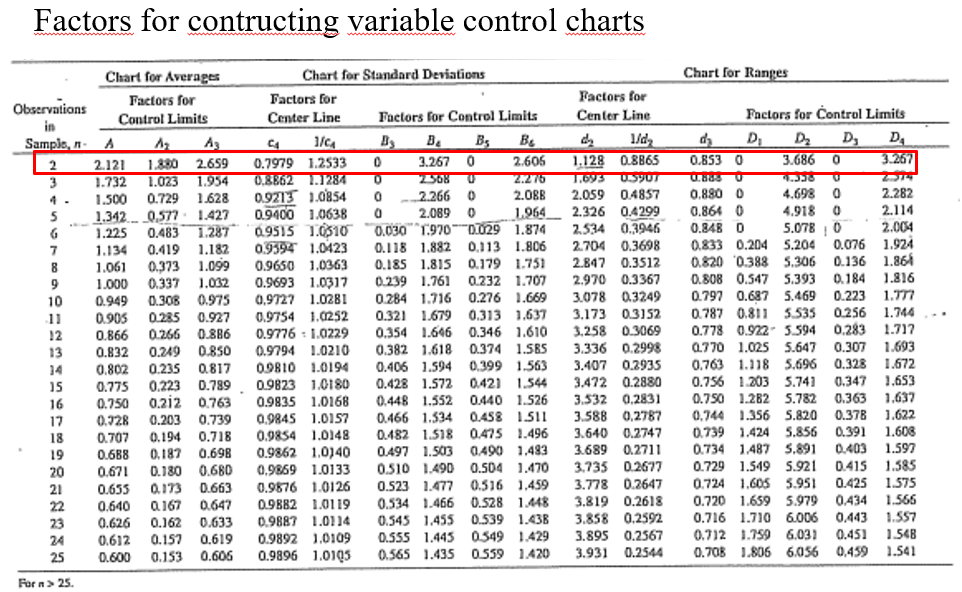

In [ ]:
# Get d2 and D4 constants using qda-toolkit
d2 = qda.constants.getd2(2)
D4 = qda.constants.getD4(2)

# make a copy of the data
df = data.copy()
# change the name of the column time to I
df.rename(columns={'GM':'I'}, inplace=True)

# Print the first 5 rows of the new dataframe
df.head()

In [ ]:
# Create columns for the upper and lower control limits
df['I_UCL'] = df['I'].mean() + (3*df['MR'].mean()/d2)
df['I_CL'] = df['I'].mean()
df['I_LCL'] = df['I'].mean() - (3*df['MR'].mean()/d2)
df['MR_UCL'] = D4 * df['MR'].mean()
df['MR_CL'] = df['MR'].mean()
df['MR_LCL'] = 0

# Print the first 5 rows of the new dataframe
df.head()

In [ ]:

# Define columns for possible violations of the control limits
df['I_TEST1'] = np.where((df['I'] > df['I_UCL']) | 
                (df['I'] < df['I_LCL']), df['I'], np.nan)
df['MR_TEST1'] = np.where((df['MR'] > df['MR_UCL']) | 
                (df['MR'] < df['MR_LCL']), df['MR'], np.nan)

# Print the first 5 rows of the new dataframe
df.head()

In [ ]:
# Plot the I chart
plt.title('I chart')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I'], color='b', linestyle='--', marker='o')
plt.plot(df['I_UCL'], color='r')
plt.plot(df['I_CL'], color='g')
plt.plot(df['I_LCL'], color='r')
plt.ylabel('Individual Value')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(df)+.5, df['I_UCL'].iloc[0], 'UCL = {:.2f}'.format(df['I_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['I_CL'].iloc[0], 'CL = {:.2f}'.format(df['I_CL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['I_LCL'].iloc[0], 'LCL = {:.2f}'.format(df['I_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(df['I_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

In [ ]:
plt.title('MR chart')
plt.plot(df['MR'], color='b', linestyle='--', marker='o')
plt.plot(df['MR_UCL'], color='r')
plt.plot(df['MR_CL'], color='g')
plt.plot(df['MR_LCL'], color='r')
plt.ylabel('Moving Range')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(df)+.5, df['MR_UCL'].iloc[0], 'UCL = {:.2f}'.format(df['MR_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['MR_CL'].iloc[0], 'CL = {:.2f}'.format(df['MR_CL'].iloc[0]), verticalalignment='center')
plt.text(len(df)+.5, df['MR_LCL'].iloc[0], 'LCL = {:.2f}'.format(df['MR_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(df['MR_TEST1'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()

> There is one point outside the control limits. 

> You can also design the control chart using the `IMR` function in `qda.ControlCharts` package.

In [ ]:
data_IMR = qda.ControlCharts.IMR(data, 'GM')

> Let's find the index of the OOC point.

In [ ]:
# Find the index of the I_TEST1 column different from NaN
OOC_idx = np.where(data_IMR['I_TEST1'].notnull())[0]
# Print the index of the OOC points
print('The index of the OOC point is: {}'.format(OOC_idx))

Index 28 (i.e. **the 29th** observation) is the one that is out of control.

> Assume we found an assignable cause for the OOC point, we have to remove it from the data.

In [ ]:
# make a copy of the data
data_2 = data.copy()
# replace the OOC point with NaN
data_2['GM'].iloc[OOC_idx] = np.nan


In [ ]:
# Plot the new control chart
data_IMR_2 = qda.ControlCharts.IMR(data_2, 'GM')

## Point 2

Determine if the values reported in the array `new_obs` are IC (use the previously designed control chart point 1).

In [ ]:
# Import the dataset
data = pd.read_csv('../../Data/general_motors.csv')
# replace the OOC point with NaN
data['GM'].iloc[OOC_idx] = np.nan

# Define the array with the new observations
new_obs = np.array((1.327, 1.594, 0.716, 1.767, 0.915, 2.524, 0.563, 2.053))

# Add the new observations to the dataset
new_data = pd.concat([data, pd.DataFrame(new_obs, columns=['GM'])], ignore_index=True)

new_data.tail(10)

Use the parameter `subset_size` to specify the number of observations to be used for the computation of the control limits (Phase 1 data).

In [ ]:
new_data_IMR = qda.ControlCharts.IMR(new_data, 'GM', subset_size=len(data))

The new data (Phase II) are in-control